In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from models import *
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib
from models.model import *

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def attribute_image_features(algorithm, input, **kwargs):
    global_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )
    return tensor_attributions

def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    # plt.savefig('picture.jpg')
    plt.show()

Noise: 0, Ground Truth: 4, Noised Result: 4
Noise: 0.5, Ground Truth: 4, Noised Result: 4
Noise: 1, Ground Truth: 4, Noised Result: 4
Noise: 1.5, Ground Truth: 4, Noised Result: 4
Noise: 2.0, Ground Truth: 4, Noised Result: 4
Noise: 2.5, Ground Truth: 4, Noised Result: 4
Noise: 3.0, Ground Truth: 4, Noised Result: 2
Noise: 3.5, Ground Truth: 4, Noised Result: 7
Noise: 4.0, Ground Truth: 4, Noised Result: 4
Noise: 4.5, Ground Truth: 4, Noised Result: 7
Noise: 5.0, Ground Truth: 4, Noised Result: 7


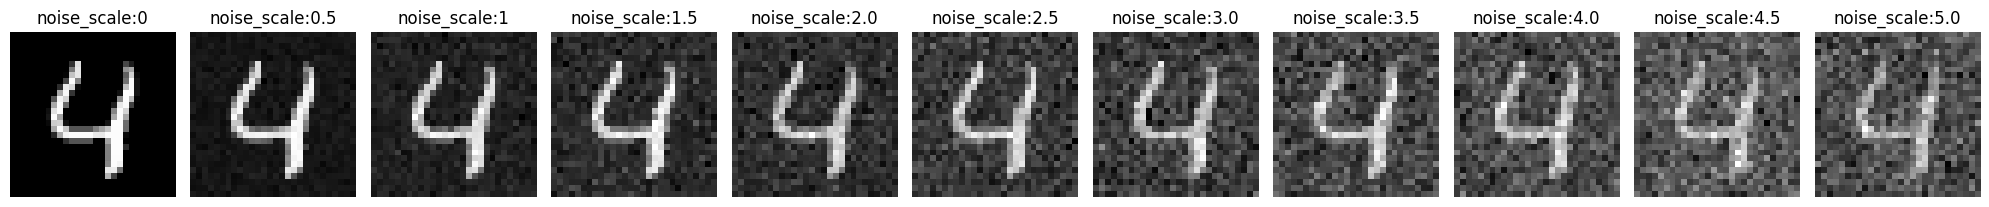

In [6]:
args = get_args.get_arg()
data_dir = './data/mnist'
sigma = 0.01
apply_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.MNIST(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = MLPMnist()
global_model.load_state_dict(torch.load(f'./checkpoints/mnist/{sigma}/best_model_mnist.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
ind = 4
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions = global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

torch.Size([28, 28])


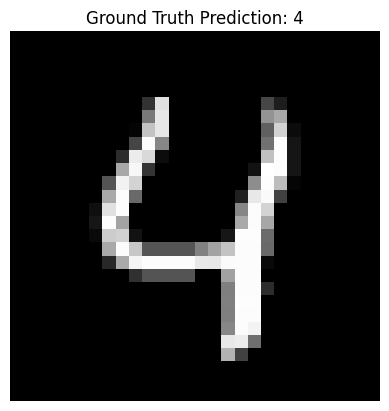

In [26]:
input_image = input.squeeze().cpu().detach()  # Remove batch dimension and move to cpu
print(input_image.size())
# Plotting
plt.imshow(input_image, cmap='gray' if input_image.ndim == 2 else None)
plt.title(f'Ground Truth Prediction: {ground_truth_prediction}')
plt.axis('off')  # Hide axis
plt.show()

In [7]:
saliency = Saliency(global_model)
ig = IntegratedGradients(global_model)
dl = DeepLift(global_model)
nt = NoiseTunnel(ig)
print('-------------------')
print('Original Image')
print('Predicted:', classes[predicted_classes],
      ' Probability:', torch.max(F.softmax(ground_truth_predictions, 1)).item())

-------------------
Original Image
Predicted: 4  Probability: 0.9985949397087097


In [5]:
def quantization_visualization(args, sigma, model, input, noise_scale, method="masked_image", sign="positive"):
    change_rates = []
    avg_noisy_image_baseline, predictions_baseline, predicted_classes_baseline, prediction_baseline = predict_with_randomized_smoothing(0, model, input, 100)
    attr_ig_baseline, delta_baseline = attribute_image_features(ig, avg_noisy_image_baseline, baselines=avg_noisy_image_baseline * 0, n_steps=1000, return_convergence_delta=True)
    num_escape = int(args.num_escape)
    grad_baseline = attr_ig_baseline.reshape(attr_ig_baseline.shape[0], -1)
    w0_baseline = grad_baseline.mean(dim=0)
    des_baseline, _ = torch.sort(grad_baseline, dim=0, descending=True)
    e11_baseline = des_baseline[num_escape:]
    e1_baseline = e11_baseline.mean(dim=0)
    e21_baseline = des_baseline[:-num_escape]
    e2_baseline = e21_baseline.mean(dim=0)
    e_baseline = torch.stack((e1_baseline, e2_baseline), dim=0)
    e_baseline = torch.abs(torch.sub(w0_baseline, e_baseline))
    e_baseline, _ = torch.max(e_baseline, dim=0)
    milestone_baseline = sigma * sigma / 2
    m_baseline = normal.Normal(0, sigma * sigma)
    g_x_baseline = torch.zeros(w0_baseline.shape[0], 3).to(device)
    g_x_baseline[:, 0] = 1 - m_baseline.cdf(torch.sub(milestone_baseline, w0_baseline))
    g_x_baseline[:, 1] = m_baseline.cdf(torch.sub(milestone_baseline, w0_baseline)) - m_baseline.cdf(torch.sub(-milestone_baseline, w0_baseline))
    g_x_baseline[:, 2] = m_baseline.cdf(torch.sub(-milestone_baseline, w0_baseline))
    g_x_p_baseline, _ = torch.sort(g_x_baseline, dim=1, descending=True)
    g_x_p_baseline = g_x_p_baseline[:, :2]
    radius_baseline = (sigma / 2 * (m_baseline.icdf(g_x_p_baseline[:, 0]) - m_baseline.icdf(g_x_p_baseline[:, 1])))
    failed_baseline = torch.gt(e_baseline, radius_baseline)
    g_x_baseline[failed_baseline == True, 0] = 0.0
    g_x_baseline[failed_baseline == True, 1] = 1.0
    g_x_baseline[failed_baseline == True, 2] = 0.0
    v_x_baseline = torch.argmax(g_x_baseline, dim=1)
    v_x_baseline = F.one_hot(v_x_baseline, num_classes=3)
    v_x_baseline = v_x_baseline.float()
    v_x_baseline[:, 0] = torch.mul(v_x_baseline[:, 0], args.gamma)
    v_x_baseline[:, 1] = torch.mul(v_x_baseline[:, 1], 0.0)
    v_x_baseline[:, 2] = torch.mul(v_x_baseline[:, 2], -args.gamma)
    v_x_baseline = torch.sum(v_x_baseline, dim=1).float()
    v_x_baseline = v_x_baseline.reshape(grad_baseline.shape).to(device)
    grad_baseline = v_x_baseline
    tensor_28x28_baseline = grad_baseline.squeeze().cpu().detach().reshape(28, 28)
    attr_ig_baseline = np.transpose(tensor_28x28_baseline.detach().numpy(), (1, 0))
    count_ig1 = attr_ig_baseline

    for i in noise_scale:
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(i, model, input, 100)
        attr_ig, delta = attribute_image_features(ig, avg_noisy_image, baselines=avg_noisy_image * 0, n_steps=1000, return_convergence_delta=True)
        grad = attr_ig.reshape(attr_ig.shape[0], -1)
        w0 = grad.mean(dim=0)
        des, _ = torch.sort(grad, dim=0, descending=True)
        e11 = des[num_escape:]
        e1 = e11.mean(dim=0)
        e21 = des[:-num_escape]
        e2 = e21.mean(dim=0)
        e = torch.stack((e1, e2), dim=0)
        e = torch.abs(torch.sub(w0, e))
        e, _ = torch.max(e, dim=0)
        milestone = sigma * sigma / 2
        m = normal.Normal(0, sigma * sigma)
        g_x = torch.zeros(w0.shape[0], 3).to(device)
        g_x[:, 0] = 1 - m.cdf(torch.sub(milestone, w0))
        g_x[:, 1] = m.cdf(torch.sub(milestone, w0)) - m.cdf(torch.sub(-milestone, w0))
        g_x[:, 2] = m.cdf(torch.sub(-milestone, w0))
        g_x_p, _ = torch.sort(g_x, dim=1, descending=True)
        g_x_p = g_x_p[:, :2]
        radius = (sigma / 2 * (m.icdf(g_x_p[:, 0]) - m.icdf(g_x_p[:, 1])))
        failed = torch.gt(e, radius)
        g_x[failed == True, 0] = 0.0
        g_x[failed == True, 1] = 1.0
        g_x[failed == True, 2] = 0.0
        v_x = torch.argmax(g_x, dim=1)
        v_x = F.one_hot(v_x, num_classes=3)
        v_x = v_x.float()
        v_x[:, 0] = torch.mul(v_x[:, 0], args.gamma)
        v_x[:, 1] = torch.mul(v_x[:, 1], 0.0)
        v_x[:, 2] = torch.mul(v_x[:, 2], -args.gamma)
        v_x = torch.sum(v_x, dim=1).float()
        v_x = v_x.reshape(grad.shape).to(device)
        grad = v_x
        tensor_28x28 = grad.squeeze().cpu().detach().reshape(28, 28)
        attr_ig = np.transpose(tensor_28x28.detach().numpy(), (1, 0))
        count_ig2 = attr_ig
        # print('-------------------')
        # print('Smoothing Image')
        # print('Predicted:', classes[prediction],
        #       ' Probability:', torch.max(F.softmax(predictions, 1)).item())
        # attr_ig = attr_ig[:, :, np.newaxis]
        # avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
        # _ = viz.visualize_image_attr(attr_ig, avg_noisy_np, method=method, sign=sign,
        #                       show_colorbar=True, title="Overlayed Integrated Gradients")
        explanation_change = count_ig2 - count_ig1
        num_zeros = np.sum(explanation_change == 0)
        explanation_change_rate = num_zeros / explanation_change.size
        change_rates.append(explanation_change_rate)
    return change_rates

In [6]:
noise_level = np.linspace(0, 10, 1001)

In [12]:
df_001 = pd.read_excel('./noise_level_change_rates001.xlsx')
df_001['Moving Average'] = df_001['Retention Rates'].rolling(window=30).mean()
df_001 = df_02.dropna(subset=['Noise Level', 'Retention Rates', 'Moving Average'])

df_01 = pd.read_excel('./noise_level_change_rates01.xlsx')
df_01['Moving Average'] = df_01['Retention Rates'].rolling(window=30).mean()
df_01 = df_01.dropna(subset=['Noise Level', 'Retention Rates', 'Moving Average'])

df_05 = pd.read_excel('./noise_level_change_rates05.xlsx')
df_05['Moving Average'] = df_05['Retention Rates'].rolling(window=30).mean()
df_05 = df_05.dropna(subset=['Noise Level', 'Retention Rates', 'Moving Average'])

df_10 = pd.read_excel('./noise_level_change_rates1.xlsx')
df_10['Moving Average'] = df_10['Retention Rates'].rolling(window=30).mean()
df_10 = df_10.dropna(subset=['Noise Level', 'Retention Rates', 'Moving Average'])

df_15 = pd.read_excel('./noise_level_change_rates15.xlsx')
df_15['Moving Average'] = df_15['Retention Rates'].rolling(window=30).mean()
df_15 = df_15.dropna(subset=['Noise Level', 'Retention Rates', 'Moving Average'])

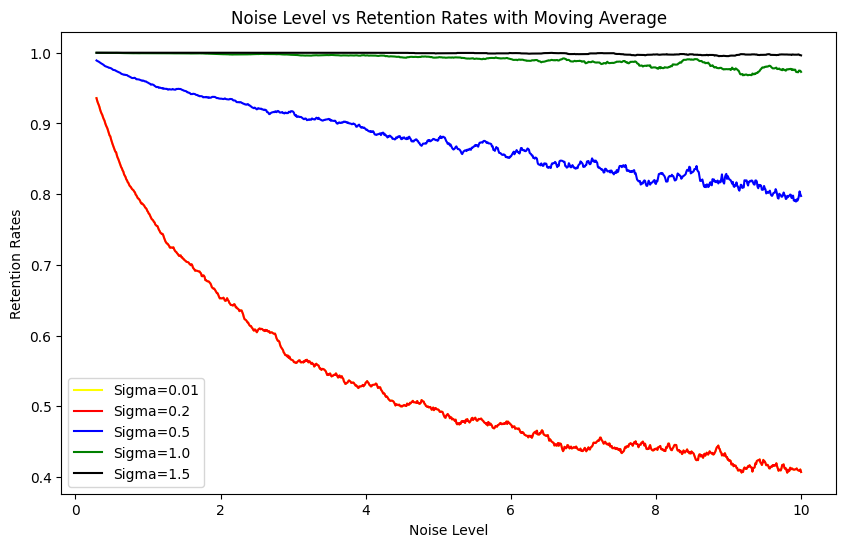

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_001['Noise Level'].to_numpy(), df_001['Moving Average'].to_numpy(), label='Sigma=0.01', color='yellow')
plt.plot(df_01['Noise Level'].to_numpy(), df_01['Moving Average'].to_numpy(), label='Sigma=0.1', color='red')
plt.plot(df_05['Noise Level'].to_numpy(), df_05['Moving Average'].to_numpy(), label='Sigma=0.5', color='blue')
plt.plot(df_10['Noise Level'].to_numpy(), df_10['Moving Average'].to_numpy(), label='Sigma=1.0', color='green')
plt.plot(df_15['Noise Level'].to_numpy(), df_15['Moving Average'].to_numpy(), label='Sigma=1.5', color='black')
plt.xlabel('Noise Level')
plt.ylabel('Retention Rates')
plt.title('Noise Level vs Retention Rates with Moving Average')
plt.legend()
plt.savefig('retention_rate.jpg')
plt.show()

In [ ]:
change_rates = quantization_visualization(args=args, sigma=0.1, model=global_model, input=input, noise_scale=noise_level,
                           method='masked_image', sign='positive')
df = pd.DataFrame({
    'Noise Level': noise_level,
    'Retention Rates': change_rates
})
excel_path = './noise_level_change_rates01.xlsx'
df.to_excel(excel_path, index=False)

In [ ]:
change_rates = quantization_visualization(args=args, sigma=0.2, model=global_model, input=input, noise_scale=noise_level,
                           method='masked_image', sign='positive')
df = pd.DataFrame({
    'Noise Level': noise_level,
    'Change Rates': change_rates
})
excel_path = './noise_level_change_rates02.xlsx'
df.to_excel(excel_path, index=False)

In [ ]:
change_rates = quantization_visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=noise_level,
                           method='masked_image', sign='positive')
df = pd.DataFrame({
    'Noise Level': noise_level,
    'Change Rates': change_rates
})
excel_path = './noise_level_change_rates05.xlsx'
df.to_excel(excel_path, index=False)

In [ ]:
change_rates = quantization_visualization(args=args, sigma=1.0, model=global_model, input=input, noise_scale=noise_level,
                           method='masked_image', sign='positive')
df = pd.DataFrame({
    'Noise Level': noise_level,
    'Change Rates': change_rates
})
excel_path = './noise_level_change_rates1.xlsx'
df.to_excel(excel_path, index=False)

In [20]:
change_rates = quantization_visualization(args=args, sigma=1.5, model=global_model, input=input, noise_scale=noise_level,
                           method='masked_image', sign='positive')
df = pd.DataFrame({
    'Noise Level': noise_level,
    'Change Rates': change_rates
})
excel_path = './noise_level_change_rates15.xlsx'
df.to_excel(excel_path, index=False)

In [24]:
def visualization(args, sigma, model, input, noise_scale, method="masked_image", sign="positive"):
    num_escape = int(args.num_escape)
    avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise_scale, model, input, 100)
    attr_ig, delta = attribute_image_features(ig, avg_noisy_image, baselines=avg_noisy_image * 0, n_steps=1000, return_convergence_delta=True)
    grad = attr_ig.reshape(attr_ig.shape[0], -1)
    w0 = grad.mean(dim=0)
    des, _ = torch.sort(grad, dim=0, descending=True)
    e11 = des[num_escape:]
    e1 = e11.mean(dim=0)
    e21 = des[:-num_escape]
    e2 = e21.mean(dim=0)
    e = torch.stack((e1, e2), dim=0)
    e = torch.abs(torch.sub(w0, e))
    e, _ = torch.max(e, dim=0)
    milestone = sigma * sigma / 2
    m = normal.Normal(0, sigma * sigma)
    g_x = torch.zeros(w0.shape[0], 3).to(device)
    g_x[:, 0] = 1 - m.cdf(torch.sub(milestone, w0))
    g_x[:, 1] = m.cdf(torch.sub(milestone, w0)) - m.cdf(torch.sub(-milestone, w0))
    g_x[:, 2] = m.cdf(torch.sub(-milestone, w0))
    g_x_p, _ = torch.sort(g_x, dim=1, descending=True)
    g_x_p = g_x_p[:, :2]
    radius = (sigma / 2 * (m.icdf(g_x_p[:, 0]) - m.icdf(g_x_p[:, 1])))
    failed = torch.gt(e, radius)
    g_x[failed == True, 0] = 0.0
    g_x[failed == True, 1] = 1.0
    g_x[failed == True, 2] = 0.0
    v_x = torch.argmax(g_x, dim=1)
    v_x = F.one_hot(v_x, num_classes=3)
    v_x = v_x.float()
    v_x[:, 0] = torch.mul(v_x[:, 0], args.gamma)
    v_x[:, 1] = torch.mul(v_x[:, 1], 0.0)
    v_x[:, 2] = torch.mul(v_x[:, 2], -args.gamma)
    v_x = torch.sum(v_x, dim=1).float()
    v_x = v_x.reshape(grad.shape).to(device)
    grad = v_x
    tensor_28x28 = grad.squeeze().cpu().detach().reshape(28, 28)
    attr_ig = np.transpose(tensor_28x28.detach().numpy(), (1, 0))
    count_ig2 = attr_ig
    print('-------------------')
    print('Smoothing Image')
    print('Predicted:', classes[prediction],
          ' Probability:', torch.max(F.softmax(predictions, 1)).item())
    attr_ig = attr_ig[:, :, np.newaxis]
    avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
    print(attr_ig.size)
    print(avg_noisy_np.size)
    _ = viz.visualize_image_attr(attr_ig, avg_noisy_np, method=method, sign=sign,
                          show_colorbar=True, title="Overlayed Integrated Gradients")

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9986069798469543


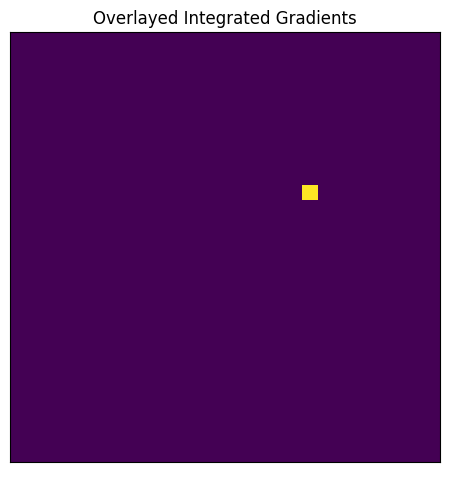

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9987125396728516


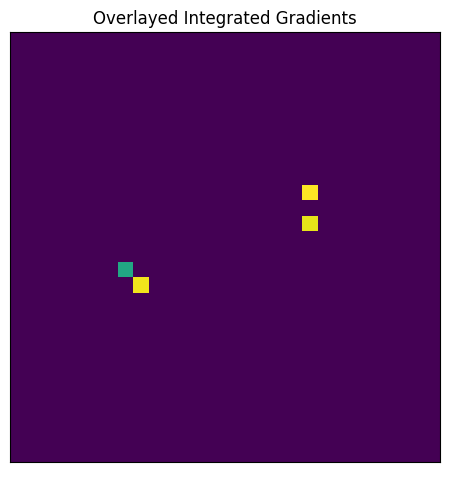

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9993587136268616


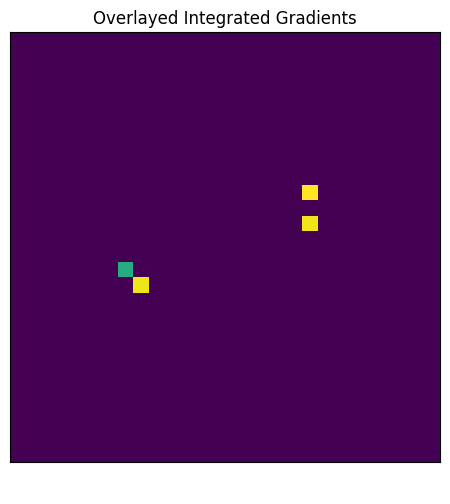

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9999774694442749


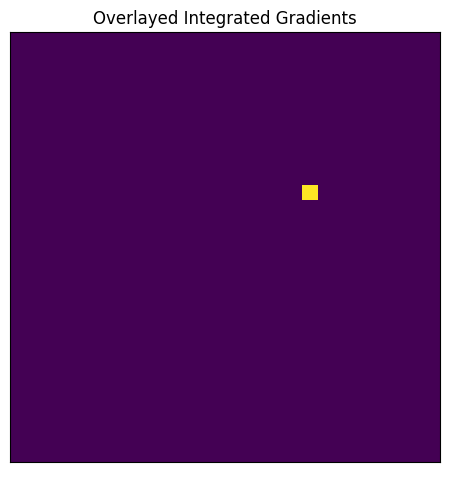

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9998441934585571


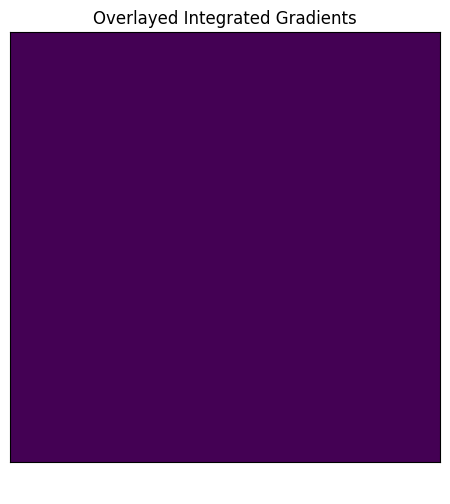

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9999781847000122


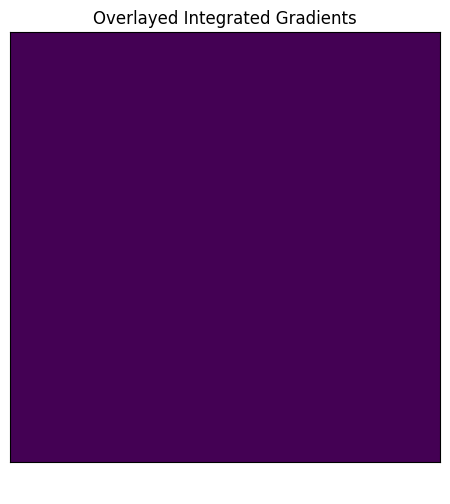

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9999426603317261


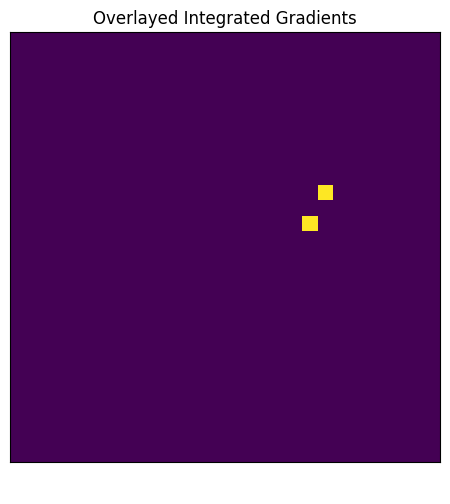

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9999938011169434


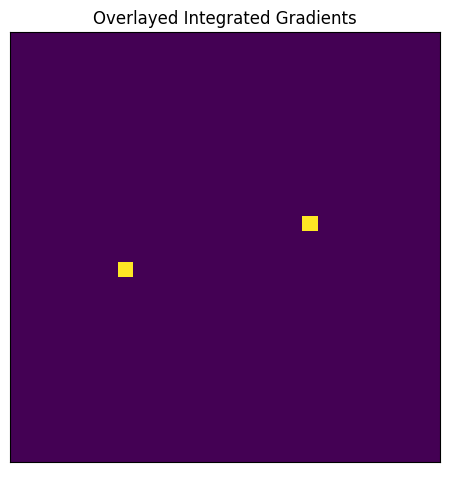

In [23]:
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.001,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.1,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.5,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.9,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=1.0,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=1.5,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=2.0,
                           method='masked_image', sign='positive')
#Noise0.5_Confi1.0_Mnist4.png

-------------------
Smoothing Image
Predicted: 4  Probability: 0.998688280582428


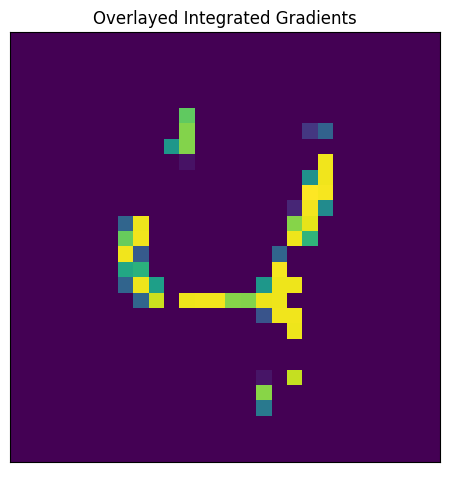

In [10]:
visualization(args=args, sigma=0.01, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9987032413482666


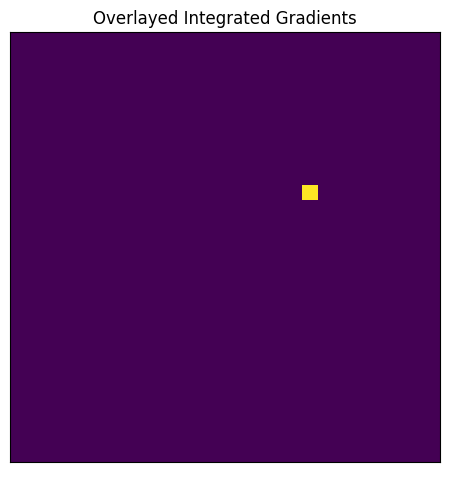

In [11]:
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9986959099769592


AssertionError: Cannot normalize by scale factor = 0

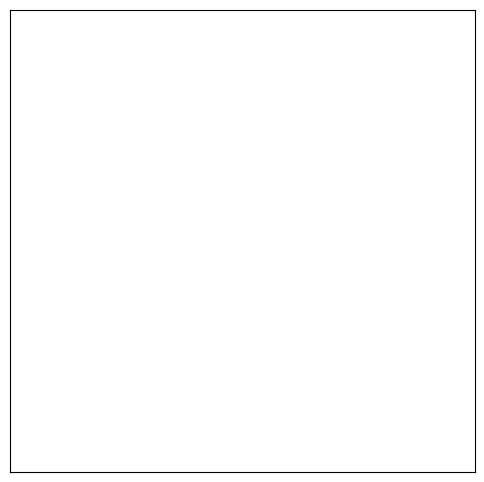

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9690296649932861


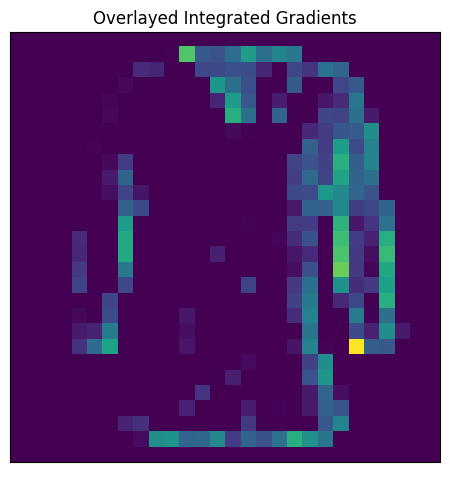

In [8]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.5,
                           method='original_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9950793981552124


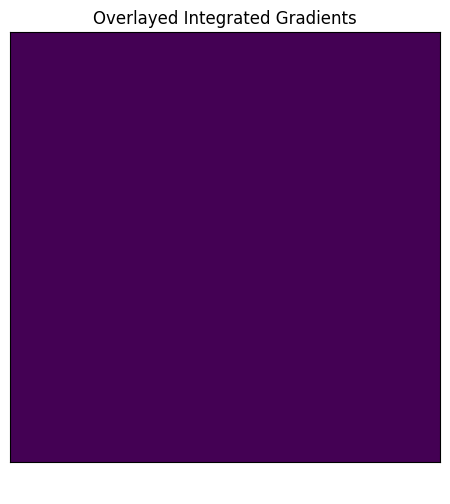

In [64]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.9,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9999667406082153


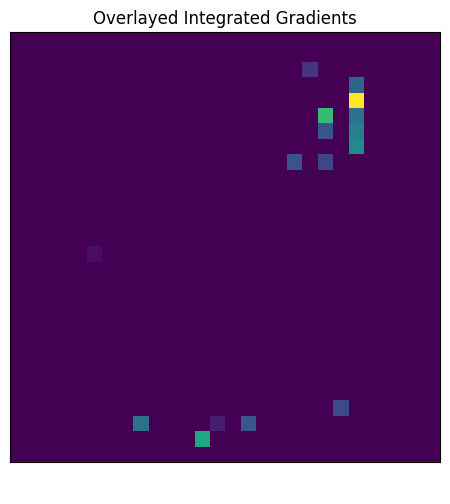

In [65]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.0,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


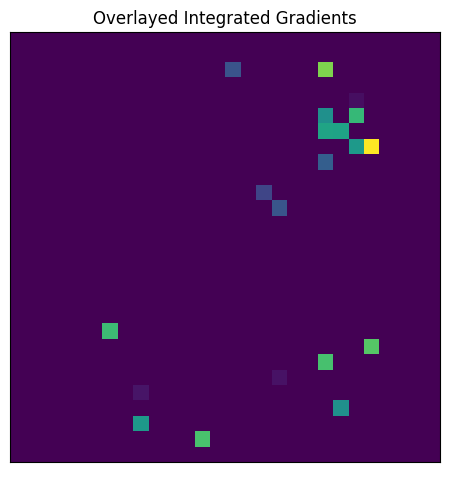

In [66]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.5,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


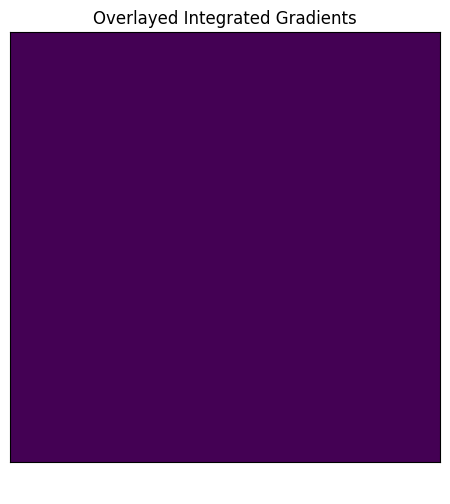

In [67]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=2.0,
                           method='masked_image', sign='positive')